# ADS 599 Team 7 Final Project

## Image Classification For Pneumonia Detection Using Chest X-Ray Images

#### University of San Diego - Applied Data Science
#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

#### Github Link: https://github.com/dingyiduan7/ADS599_Capstone_Image_Recognition

### Load the necessary packages

In [3]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from random import randint

from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tensorflow import keras  
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, MaxPooling2D, Activation, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,confusion_matrix

## Stage 1: Data Loading and Exploratory Data Analysis (EDA)

Let's set the paths for our three folders with pre-split train, val and test images.
Each folder contains two subfolders: "NORMAL" and "PNEUMONIA" labeled images.

In [ ]:
# set the path for all three datasets
#data_dir = Path("D:/USD-ADS_graduate/ADS-599/chest_xray/")
#train_dir = data_dir/"train"
#val_dir = data_dir/"val"
#test_dir = data_dir/"test"

In [ ]:
# set the path for all three datasets
#data_dir = Path("C:/Users/abby0/OneDrive/Desktop/MSADS/ADS-599 Capstone/Project/chest_xray/")
#train_dir = data_dir/"train"
#val_dir = data_dir/"val"
#test_dir = data_dir/"test"

In [4]:
# set the path for all three datasets
data_dir = Path("/Users/evachow/Documents/Documents - Eva’s Mac mini/USD/ADS599/Capstone/chest_xray")
train_dir = data_dir/"train"
val_dir = data_dir/"val"
test_dir = data_dir/"test"

In [11]:
# create a function to load the data into dataframes from each folder with corresponding labels

def load_data(data_path):
    normal_dir = data_path/"NORMAL"
    pneum_dir = data_path/"PNEUMONIA"
    
    # images are in .jpeg format
    normal_img = normal_dir.glob('*.jpeg')
    pneum_img = pneum_dir.glob('*.jpeg')
    
    img_data = []
    img_label = []
    
    for img in normal_img:
        img_data.append(img)
        img_label.append('NORMAL')
        
    for img in pneum_img:
        img_data.append(img)
        img_label.append('PNEUMONIA')
    df = pd.DataFrame(img_data,columns=['images'])
    df['label'] = img_label
    df = df.reset_index(drop=True)
    
    return df

In [13]:
# apply the created function
df_train = load_data(train_dir)
df_val = load_data(val_dir)
df_test = load_data(test_dir)

# we'll randomly sample and check image labeling
print(df_train.sample(10))

                                                 images      label
4434  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
395   /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL
4749  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
566   /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL
1112  /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL
3431  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
4959  /Users/evachow/Documents/Documents - Eva’s Mac...  PNEUMONIA
1196  /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL
952   /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL
582   /Users/evachow/Documents/Documents - Eva’s Mac...     NORMAL


In [14]:
# let's look at the data size
print('The training data has a shape of:',df_train.shape)
print('The validate data has a shape of:',df_val.shape)
print('The test data has a shape of:',df_test.shape)

The training data has a shape of: (5216, 2)
The validate data has a shape of: (16, 2)
The test data has a shape of: (624, 2)


<AxesSubplot: title={'center': 'Training Data Label Distribution'}>

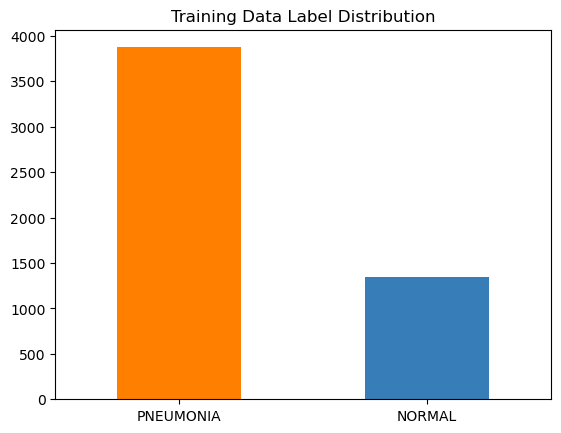

In [15]:
# let's visualize the distribution of "NORMAL" vs "PNEUMONIA" images
df_train['label'].value_counts().plot(kind='bar',rot=0,title="Training Data Label Distribution",color=['#ff7f00','#377eb8'])

There is a clear data imbalance, with images labeled "PNEUMONIA" having more than twice as many images as "NORMAL" labeled images.

In [18]:
# we'll oversample our minority ("NORMAL" labeled images) by duplicating our minority data
df_train['images'][0]

PosixPath('/Users/evachow/Documents/Documents - Eva’s Mac mini/USD/ADS599/Capstone/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg')

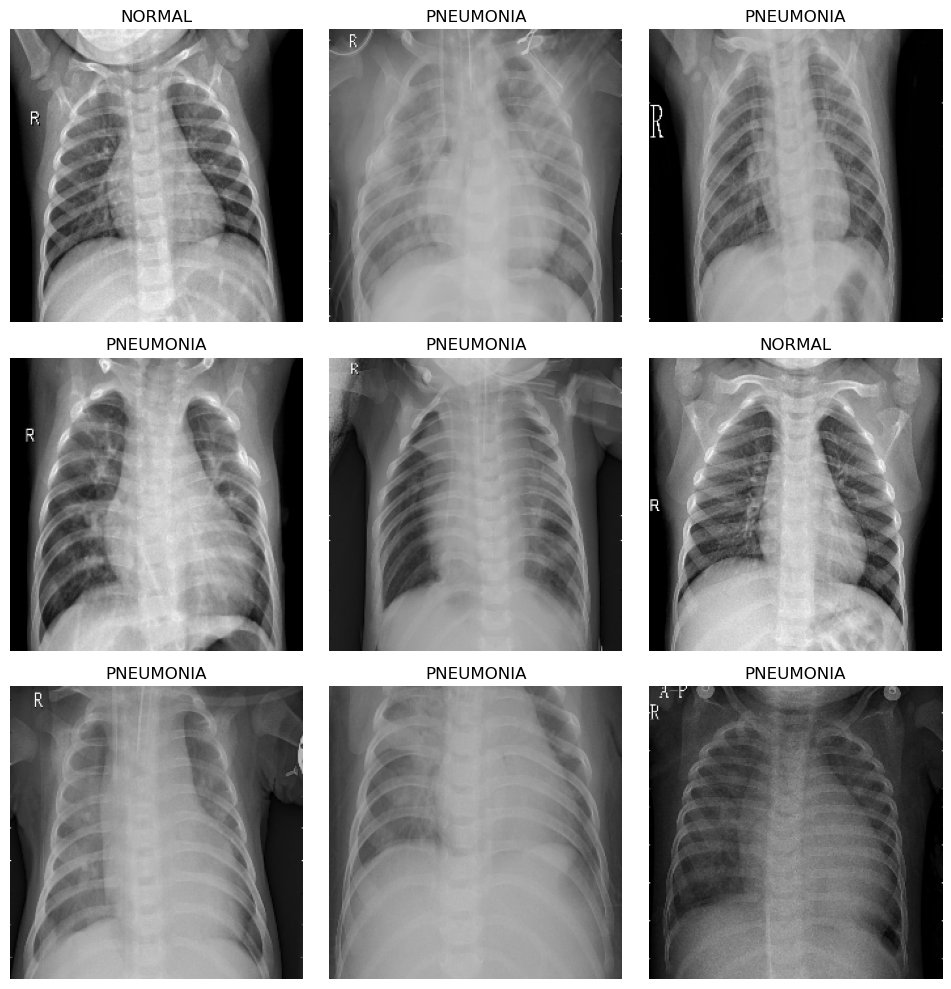

In [19]:
# let's randomly sample a few images to see if we can observe any visual differences between the two labels
plt.figure(figsize=(10,10))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    j = randint(0, len(df_train))
    img_path = str(df_train['images'][j])
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224,224))
    plt.title(df_train['label'][j])
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

Looking at the images, we can see that:  
- "PNEUMONIA" labeled images appear to have cloudier imagery within the ribcage, though this observation is subjective and not definitive. 
- There are variations in image quality, with some images appearing "sharper", "cloudier", and "darker", though these observations are also subjective. 
- Some images have been labeled to represent the the orientation of the body, which is critical to note as the position of the body results in significant image differences due to the anatomy of the human body (note that the anatomical left lung is smaller than the right and that anatomical positioning assumes looking at a human body with their back facing toward you)

## Stage 2: Data Cleaning and Preprocessing

### Image Formatting/ Image Augmentation


Reference: https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

We'll start by taking one image from our training set and applying various image augmentation and segmentation methods in order to see the outcome.

(-0.5, 223.5, 223.5, -0.5)

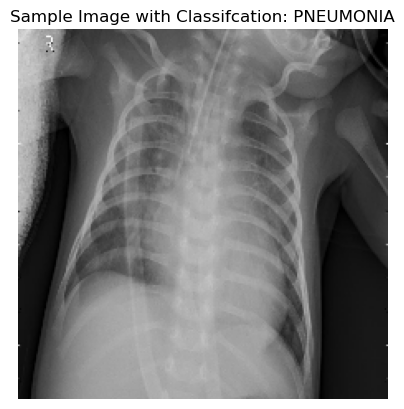

In [27]:
sample_ind = randint(0, len(df_train))
sample_path= str(df_train['images'][sample_ind])
sample_img = cv2.imread(sample_path)
sample_img = cv2.resize(sample_img,(224,224))
plt.title('Sample Image with Classifcation: %s'%df_train['label'][sample_ind])
plt.imshow(sample_img)
plt.axis('off')

In [23]:
# this function will make it easier to return our original, unaltered image for comparison
def original(img):
    return img

#### 1. Resizing 
Resize the image to a specified length and width

In [24]:
# this function will return an image that is 50x50, which is smaller than our original image
def resizing(img):
    res_img = cv2.resize(img, (50,50)) # this 50x50 size indicates pixel width and length
    return res_img

#### 2. Gray Scaling
The image will be converted to gray scale (range of gray shades from white to black). Each pixel will be assigned a value based on how dark it is. These values are converted to numbers, which will be put into an array for computations to be performed on.

In [25]:
# this function will gray-scale an image using the cv2 package
def gray_scale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_img

#### 3. Reflection/Flip
An image can be flipped vertically or horizontally. While some frameworks do not provide a function for vertical flips, this can be achieved by rotating an image 180 degrees and then performing a horizontal flip.

In [26]:
# this function will flip the image vertically by using cv2.flip(img,1), swapping the left and right sides of the image
# to flip horizontally, use cv2.flip(img,0)
def ref_flip(img):
    flip_img = cv2.flip(img,1)
    return flip_img

#### 4. Gaussian Blurring
Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise.

In [28]:
# this functions applies a Gaussian blur over our image
# the intensity of the blur can be adjusted by adjusting sigma
def gau_blur(img):
    blur_img = ndimage.gaussian_filter(img, sigma= 5.11)
    return blur_img

#### 5. Histogram Equalization
Histogram equalization increases global contrast of an image using the image intensity histogram. This method needs no parameter, but it can result in unnatural looking images.

In [29]:
# this function will attempt to increase image contrast by taking the most frequent intensity values and spreading them out
def hist_eq(img):
    img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
    hist_img= cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_img

#### 6. Rotation
Rotating an image turns the image. Note that this might not preserve the original dimensions of an image. This dimension preservation depends largely on the angle of rotation.

In [30]:
# this function will rotate our image
def rotation(img):
    rows,cols = img.shape[0],img.shape[1]
    randDeg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
    rot_img = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT)
    return rot_img 

#### 7. Channel Conversion
Some images are in  greyscale (1 channel), therefore convert them to 3 channel

In [31]:
def channel_con(img):
    if img.shape[2]==1:
        img = dstack([img,img,img])
    return img 

#### 8. Color Conversion
Images read using cv2 are in BGR format(by default), convert it to RGB.

In [33]:
def color_con(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

#### Augmentation Comparison

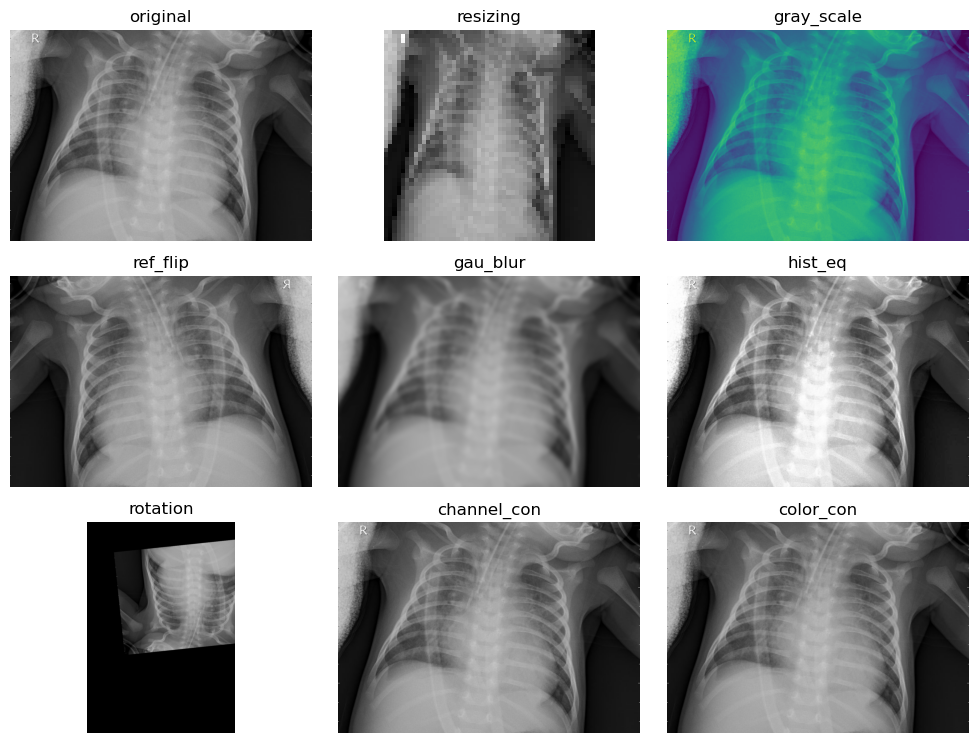

In [34]:
# let's create an image augmentation and segmentation pipeline to see the effects on our original image
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]

plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(4,3,img_aug.index(aug)+1)
    sample_img = cv2.imread(sample_path)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

Upon observation, we can see that:

- When resizing our image, this will result in an image altered resolution. 
- In gray-scaling, because our images were already gray-scale, this appears to have converted the image using another color space.
- In ref_flip, while this successfully flipped our image vertically, we will choose to forgo this augmentation technique due to the medical importance of anatomical positioning (i.e. left versus right sides of the body).
- Gaussian blue has smoothed out the harsh edges within the image. This may prove unhelpful in detecting aspects of the image that may help in classifying "PNEUMONIA" images.
- Histogram equalization has increased the constrast of our images.
- Rotation has disorted image size and quality. We will forgo this augmentation technique as it seems unhelpful.
- Channel conversion does not appear to have caused major impacts to the image. This may be forgone in our augmentation techniques.
- Color conversion also does not appear to have major impacts on the image.

#### Image when all augmentation is performed.

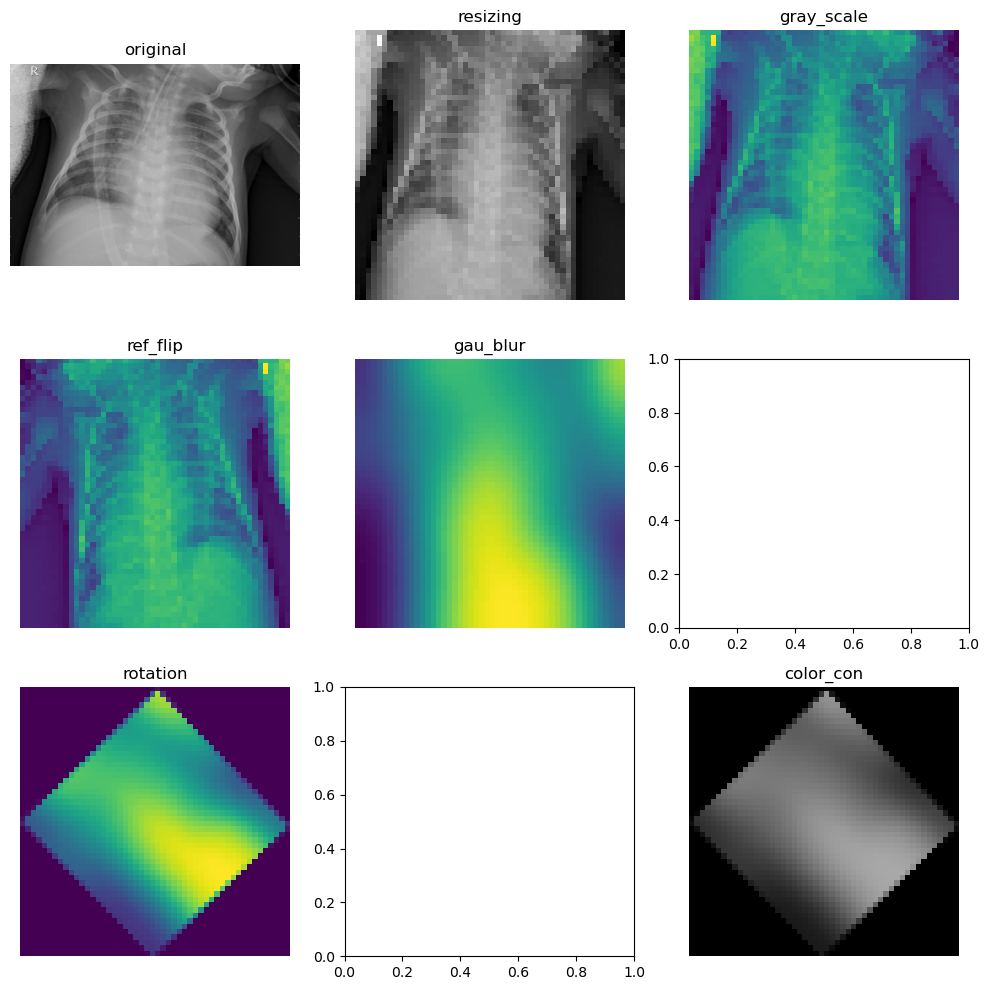

In [35]:
img_aug = [original, resizing, gray_scale, ref_flip, gau_blur, hist_eq, rotation, channel_con, color_con]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    try:
        ax = plt.subplot(3,3,img_aug.index(aug)+1)
        sample_img = aug(sample_img)
        plt.title(aug.__name__)
        plt.imshow(sample_img)
        plt.axis('off')
        plt.tight_layout()  
    except:
        pass

Obviously we cannot perform all processing steps to the same image all together, it is only rational for us to find the most optimal way to prepare the image.

Let's try with the following augmentation:
- resizing to 224 x 224
- gray scaling
- histogram equalization

In [ ]:
# we'll resize the image to better quality
def resizing2(img):
    res_img = cv2.resize(img, (224,224)) # using 224 for better pixel size
    return res_img

In [ ]:
img_aug = [resizing2, color_con, gray_scale,]
sample_img = cv2.imread(sample_path)
plt.figure(figsize=(10,10))
for aug in img_aug:
    ax = plt.subplot(1, 3, img_aug.index(aug)+1)
    sample_img = aug(sample_img)
    plt.title(aug.__name__)
    plt.imshow(sample_img)
    plt.axis('off')
    plt.tight_layout()   

This would be a better processing procedure, hence we set our pipeline to be such.

In [ ]:
# pipeline implementation
def prepare(path, pipeline) : 
    img = cv2.imread(str(path))
    
    for transform in pipeline : 
        img = transform(img)
        
    return img

pipeline = [resizing2, color_con, gray_scale,]

### Training data

In [ ]:
df_train['images'] = df_train['images'].apply(prepare,pipeline = pipeline)

In [ ]:
df_train.head()

In [ ]:
for i in range(len(df_train)):
    df_train['images'][i] = df_train['images'][i].astype(np.float32)/255
    
df_train['label'] = df_train['label'].astype(str)
df_train['label'] = df_train['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [ ]:
df_train.sample(20)

In [ ]:
x_train = np.array([df_train['images'][i] for i in range(len(df_train))])
y_train = np.array(df_train['label'])

##### Reshape data for model without sequential 

Train dataset consists 5216 images, and each image was resize to 224 x 224 pixels, which implies each image in the dataset is represented by 224 x 224 = 50,176 integers.

In [ ]:
x_train.shape

In [ ]:
x_train_2 = x_train.reshape((x_train.shape[0], 50176))

In [ ]:
print(pd.DataFrame(x_train_2).shape)
pd.DataFrame(x_train_2).head(3)

In [ ]:
le = LabelEncoder()
y_train_2 = le.fit_transform(df_train['label'])

### Validation data

In [ ]:
df_val['images'] = df_val['images'].apply(prepare,pipeline=pipeline)

In [ ]:
for i in range(len(df_val)):
    df_val['images'][i] = df_val['images'][i].astype(np.float32)/255
    
df_val['label'] = df_val['label'].astype(str)
df_val['label'] = df_val['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [ ]:
x_val = np.array([df_val['images'][i] for i in range(len(df_val))])
y_val = np.array(df_test['label'])

##### Reshape Validate Data

In [ ]:
x_val_2 = x_val.reshape((x_val.shape[0], 50176))
y_val_2 = le.fit_transform(df_val['label'])

### Test data

In [ ]:
df_test['images'] = df_test['images'].apply(prepare,pipeline=pipeline)

In [ ]:
for i in range(len(df_test)):
    df_test['images'][i] = df_test['images'][i].astype(np.float32)/255
    
df_test['label'] = df_test['label'].astype(str)
df_test['label'] = df_test['label'].map( {'NORMAL':0 , 'PNEUMONIA':1} )

In [ ]:
x_test = np.array([df_test['images'][i] for i in range(len(df_test))])
y_test = np.array(df_test['label'])

##### Reshape Test Data

In [ ]:
x_test_2 = x_test.reshape((x_test.shape[0], 50176))
y_test_2 = le.fit_transform(df_test['label'])

## Stage 3: Model Definition and Training

### Sequential Setup

In [ ]:
model = Sequential()
model.add(Conv2D(16,(5,5), padding='valid',input_shape = (224, 224, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))
model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))
model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

### General Macine Learning Classifiers

##### SVM

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(feat_train,y_train)
svm.score(feat_test,y_test)

Without sequential 

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(x_train_2,y_train_2)
svm.score(x_test_2,y_test_2)

##### KNN

In [ ]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(feat_train,y_train)
knn.score(feat_test,y_test)

Without sequential 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(x_train_2,y_train_2)
knn.score(x_test_2,y_test_2)

##### Decision Tree

In [ ]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

In [ ]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(feat_train,y_train)
dt.score(feat_test,y_test)

Without sequential 

In [ ]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
dt.fit(x_train_2,y_train_2)
dt.score(x_test_2,y_test_2)

##### Random Forest

In [ ]:
model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(x_train)
feat_test = model_feat.predict(x_test)

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(feat_train,y_train)
rf.score(feat_test,y_test)

Without sequential 

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(x_train_2,y_train_2)
rf.score(x_test_2,y_test_2)

### Deep Learning Models

##### CNN (WIP)

In [ ]:
batch_size = 100
epochs= 100

optimizer = keras.optimizers.RMSprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, 
              metrics = ['accuracy','precision', 'recall'])

##### yolo

##### vgg16

##### ResNet50

##### EfficientNet

## Stage 4: Model performance and evaluation

## Stage 5: Model Deployment